<a href="https://www.kaggle.com/code/inzeyun/notebookc2020bf0c0?scriptVersionId=162861696" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## PHQ-9, ICD-10 Depression Scores
* Upon thinking, the explanation about this dataset is quite wrong
    * PHQ-9 scores are not longitudinal and only been used for initial diagnosis
    * [q for q in dataset.columns if q.startswith("q")] (ICD-10 Depression endpoints) is one of primary, longitudinal endpoints in the dataset
* Except of happiness.score, higher questionnarie results are bad

## Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid",palette="muted")

In [2]:
datafile="/kaggle/input/phq-9-depression-assessment/Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv"
indices=["user_id","phq.day"]
gomi=["Unnamed: 0","id","start.time","time"]

In [3]:
data=pd.read_csv(datafile).drop(gomi,axis=1).dropna(subset=["phq1","phq9"])

In [4]:
data=data.sort_values(indices)
data.sample(3)

,user_id,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,...,q11,q12,q13,q14,q16,q46,q47,happiness.score,period.name,phq.day
7675,100,1.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,3.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2,evening,14.960012
1069,9,0.0,0.0,1.0,1.0,0.0,3.0,2.0,0.0,2.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,morning,-10.472257
1810,21,0.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0,evening,-54.129954


## Take a Look

In [5]:
data.select_dtypes("number").agg([lambda q:q.isna().sum(),"mean","median","std","min","max"]).T.round(3)

,<lambda>,mean,median,std,min,max
user_id,0.0,96.957,101.000,54.196,1.000,185.000
phq1,0.0,1.784,2.000,0.971,0.000,3.000
phq2,0.0,2.068,2.000,1.030,0.000,3.000
phq3,0.0,2.077,2.000,0.992,0.000,3.000
phq4,0.0,2.396,3.000,0.837,0.000,3.000
phq5,0.0,1.585,2.000,1.153,0.000,3.000
phq6,0.0,1.848,2.000,1.203,0.000,3.000
phq7,0.0,1.778,2.000,1.066,0.000,3.000
phq8,0.0,1.044,1.000,1.011,0.000,3.000
phq9,0.0,1.262,1.000,1.129,0.000,3.000


<Axes: >

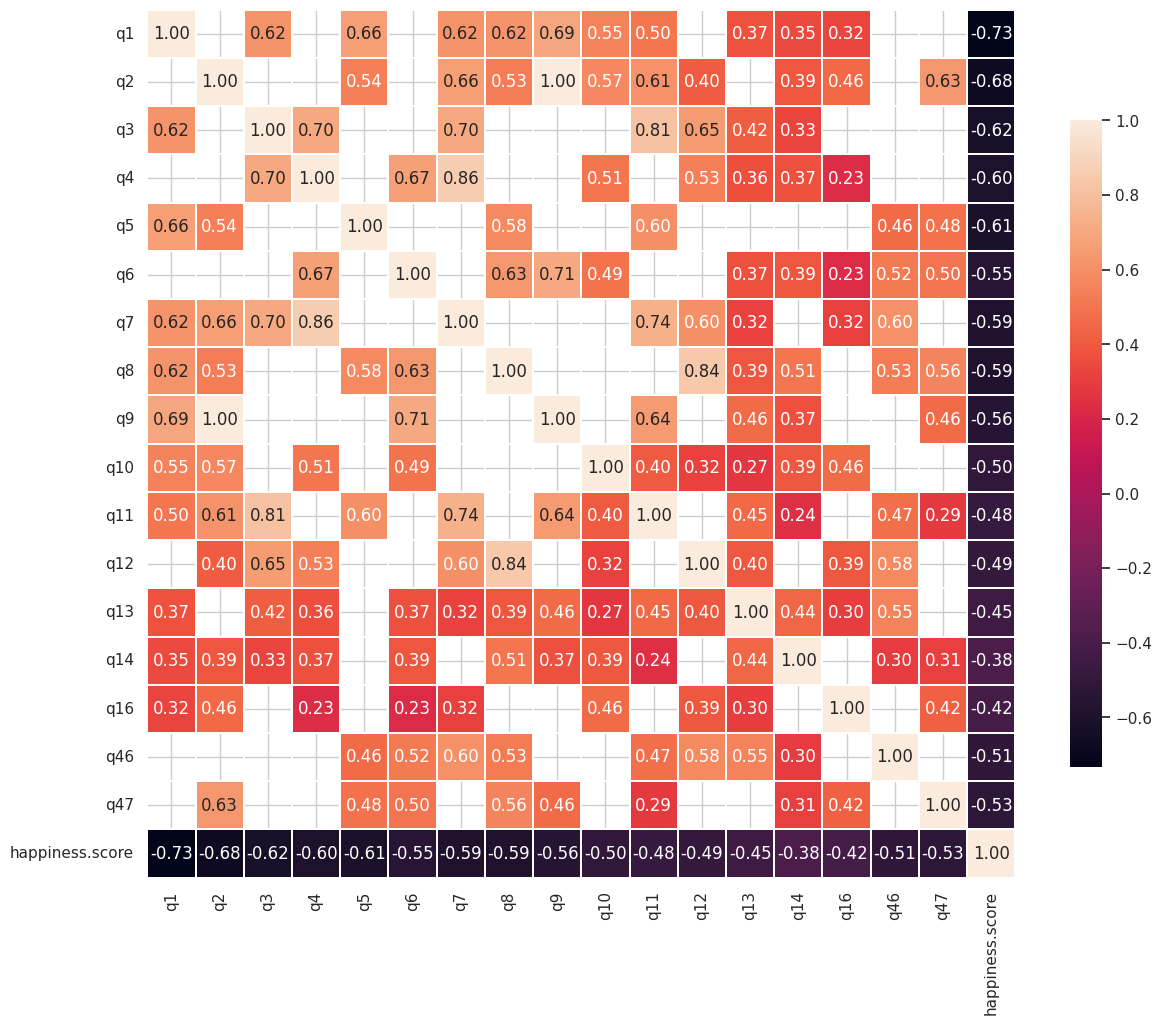

In [6]:
fg,ax=plt.subplots(figsize=(14,14))
sns.heatmap(
    data[[q for q in data.columns if q.startswith("q")]+["happiness.score"]].dropna(thresh=data.shape[0]*.1,axis=1).corr(),
    annot=True,fmt=".2f",linewidth=.25,square=True,cbar_kws={"shrink":.6},
    ax=ax)

## Make Spots
* Data is longitudinal and having 'phq.day' absolute time values
* I'm going to have more samples per spot, and spots would be an index for most values

In [7]:
mms=MinMaxScaler()
data["timedelta"]=data.groupby("user_id")["phq.day"].transform(
    lambda q:mms.fit_transform(q.to_numpy().reshape(-1,1)).reshape(-1)
)

In [8]:
longitudinalQs=[q for q in data.columns if q.startswith("q")]

data["spot"]=pd.qcut(data.timedelta,10,[q for q in range(1,11)])
perSpot=data.groupby("spot")[longitudinalQs].mean()

/tmp/ipykernel_18/1203593879.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perSpot=data.groupby("spot")[longitudinalQs].mean()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


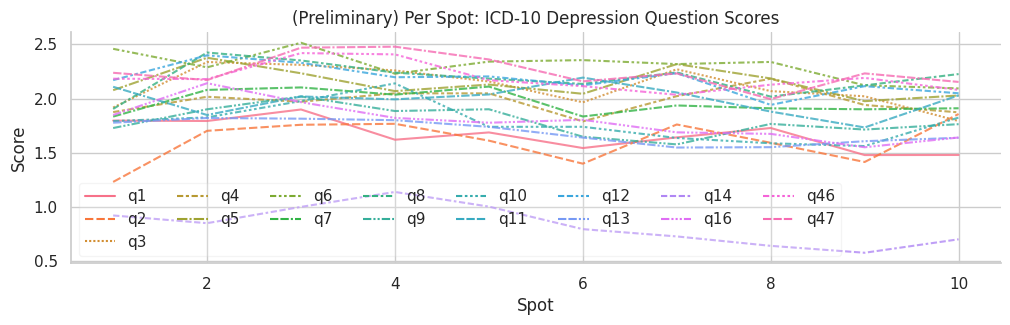

In [9]:
fig,ax=plt.subplots(figsize=(12,3))

sns.lineplot(perSpot,alpha=.8,ax=ax)

ax.set_title("(Preliminary) Per Spot: ICD-10 Depression Question Scores")
ax.set_xlabel("Spot")
ax.set_ylabel("Score")

sns.move_legend(
    ax,
    title=None,
    loc="lower left",
    ncols=8,
    framealpha=.2
)
sns.despine()

## Get PHQ-9 Based Diagnosis

In [10]:
phqEssential=data.loc[:,["phq1","phq2"]].gt(1).all(axis=1)

phqZasal=data.loc[:,["phq9"]].gt(0).all(axis=1)

phqShaded=data.loc[phqEssential,[f"phq{q}" for q in range(1,9)]].gt(1).sum(axis=1)+phqZasal
phqShaded=phqShaded.fillna(0)
data["phqShaded"]=phqShaded

phq=data[[q for q in data.columns if q[-1].isdigit() and q[:3]=="phq"]].sum(axis=1)
data["phq"]=phq

In [11]:
idd=data[data.index.isin(data.groupby("user_id")["phq.day"].idxmin())].phqShaded.gt(3)
idd=data.user_id.isin(data[data.index.isin(idd.index)].user_id).rename("idd").apply(lambda q:"idd" if q else "")
idd.value_counts()

mdd=data.phqShaded.gt(4).rename("mdd").apply(lambda q:"mdd" if q else "")

odd=((1<data.phqShaded) * (data.phqShaded<5)).rename("odd").apply(lambda q:"odd" if q else "")

In [12]:
diag=(mdd+odd).rename("diag")
diag.loc[diag==""]="none"

data=pd.concat([ 
    data.drop("phq.day",axis=1),
    diag
],axis=1)

## Age Binning
* Going to have 5 bins for age

In [13]:
ageBin=pd.qcut(data.age,5)
data["age.bin"]=ageBin.cat.rename_categories(
    [f"{q.left:.1f}-{q.right:.1f}" for q in ageBin.cat.categories]
)

In [14]:
data_=data.melt(["user_id","spot","sex","age.bin","period.name","diag"],longitudinalQs)
data_.sample(5)

,user_id,spot,sex,age.bin,period.name,diag,variable,value
229655,133,9,female,NaN,evening,none,q16,NaN
10249,127,5,female,12.0-20.0,morning,none,q1,NaN
245016,133,3,female,NaN,evening,none,q46,NaN
101199,100,6,female,NaN,evening,none,q7,NaN
79137,9,4,female,20.0-25.0,midday,none,q6,4.0


## Per Category Plots
* Going to plot ICD-10 score means per categorical values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.02, 0.5, 'ICD-10 Mean Score')

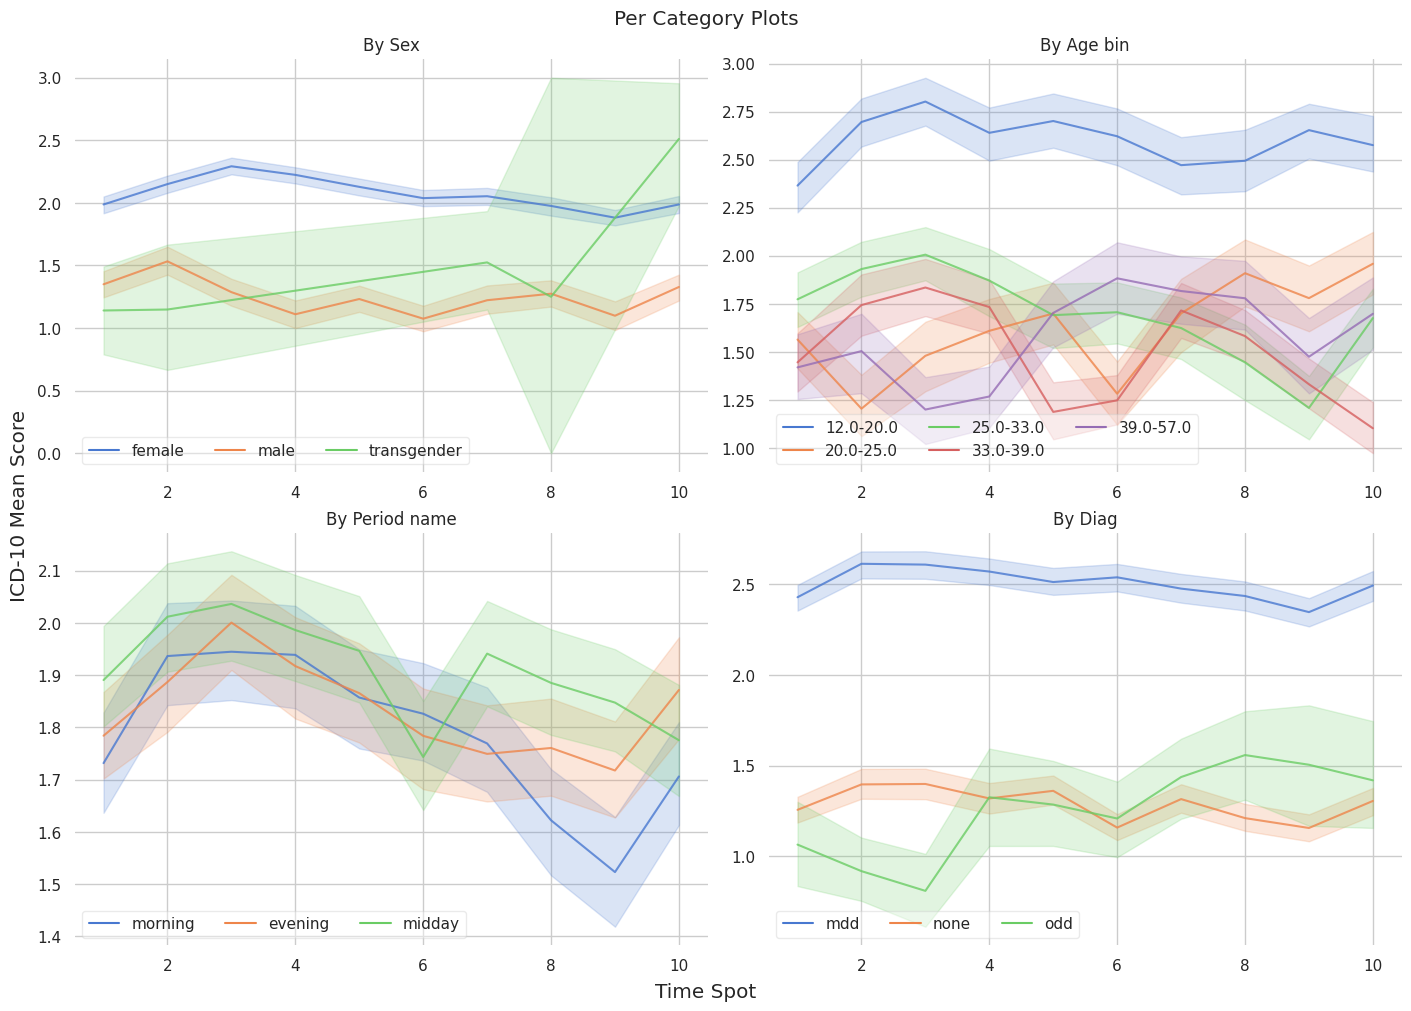

In [15]:
fg,ax=plt.subplots(2,2,figsize=(14,10),layout="constrained")

for q in list(zip(data_.columns[2:6],ax.ravel())):
    qLabel=q[0].replace("."," ").capitalize()

    sns.lineplot(
        data_,
        x="spot",
        y="value",
        hue=q[0],
        ax=q[1],
        alpha=.8,
    ).set(title=f"By {qLabel}",xlabel=None,ylabel=None)

    sns.move_legend(
        q[1],
        loc="lower left",
        title=None,
        ncols=3,
        framealpha=.4
    )

sns.despine(bottom=True,left=True)

fg.suptitle("Per Category Plots")
fg.supxlabel("Time Spot")
fg.supylabel("ICD-10 Mean Score")


## Categorical Score as Bins
* Like most self-report questionnaires, PHQ-9 scores can be used for categories
* I'm going to use the 9th question relevant to self-harm

In [16]:
byPhq=data.melt(["spot","phq9"],longitudinalQs)
byPhq.sample(3)

,spot,phq9,variable,value
89343,10,0.0,q6,0.0
22821,10,3.0,q2,NaN
33869,4,3.0,q3,NaN


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

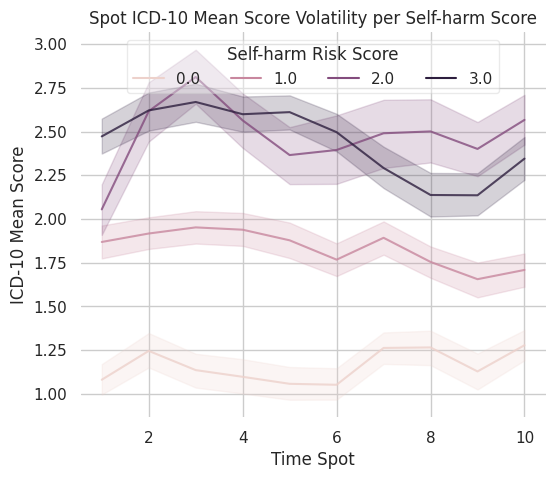

In [17]:
fg,ax=plt.subplots(figsize=(6,5))

sns.lineplot(
    byPhq,
    x="spot",
    y="value",
    hue="phq9",
    alpha=.8,
    ax=ax).set(title="Spot ICD-10 Mean Score Volatility per Self-harm Score",
        xlabel="Time Spot",
        ylabel="ICD-10 Mean Score")

sns.move_legend(
    ax,
    loc="upper center",
    title="Self-harm Risk Score",
    ncols=4,
    framealpha=.4
)

sns.despine(left=True,bottom=True)